In [1]:
!git clone https://github.com/cfteach/modules.git
!pip install scikit-optimize 

fatal: destination path 'modules' already exists and is not an empty directory.


In [2]:
%load_ext autoreload 
%autoreload 2

from IPython.display import display, Math, Latex


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import AI4NP_detector_opt.sol2.detector2 as detector2 
import modules.detector2 as detector2
import re

## Create detector geometry and simulate tracks  

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one. 

A total of 8 parameters can be tuned. 

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track. 

So we want to maximize the efficiency (defined in detector.py) and minimize the cost. 

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 4.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]


::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 4.0 0.0 0.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::
# of wires:  20
:::: TRACK GENERATION ::::


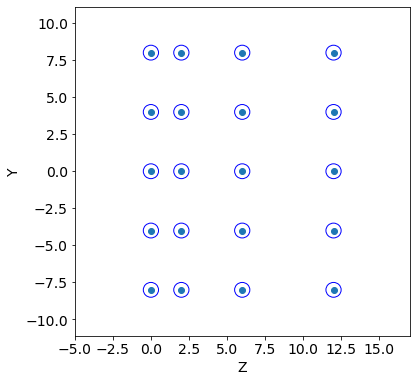

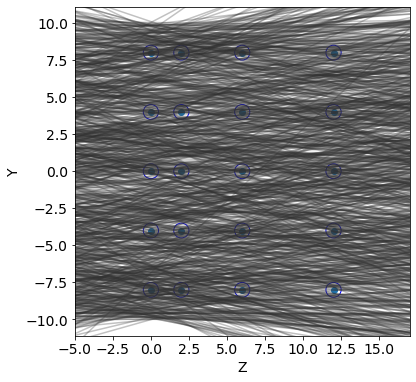

fraction of tracks detected:  0.264


In [3]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1
N_tracks = 1000


print("::::: BASELINE PARAMETERS :::::")
R = 0.5 #.5  
pitch = 4.0 #10.0  
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)


detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
t = detector2.Tracks(b_min= y_min, b_max=y_max, alpha_mean=0, alpha_std=0.2) #b_min=-100, b_max=100
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
print("fraction of tracks detected: ",frac_detected)


---

### Define Objectives 

Defines the objective function of the problem that can be used in the Bayesian Optimization.


In [4]:
#------------- OBJECTIVE FUNCTION ---------------#

class Obj:

  def __init__(self,R=0.5,pitch=4.0):
    self.R = R 
    self.pitch = pitch  

  def update_pars(self,r,p):
    self.R = r 
    self.pitch = p  
    

  def objective(self,x):

    #you have to upack R, pitch if included in the BO
    y1, y2, y3, z1, z2, z3 = x 
    Z, Y = detector2.Tracker(self.R, self.pitch, y1, y2, y3, z1, z2, z3).create_geometry()
    #a track is detected if at least two wires have been hit
    val = detector2.get_score(Z, Y, tracks, self.R)[0] 
    #print(self.R, self.pitch)

    return 1. - val  # the smaller, the better.





---
# Bayesian Optimization of the Detector Geometry


You can find different options for the optimization.

We refer to sklearn optimization package: 
https://scikit-optimize.github.io/stable/ 

Different approaches for the regression part.



In [5]:
from skopt import gp_minimize, gbrt_minimize, dummy_minimize

# You can change values within pre-defined ranges 
# Below we are considering only the shifts along y and z 
# (of each plane with respect to the previous plane)

y1_min, y1_max = [0., 4.]
y2_min, y2_max = [0., 4.]
y3_min, y3_max = [0., 4.]
z1_min, z1_max = [2., 10.]
z2_min, z2_max = [2., 10.]
z3_min, z3_max = [2., 10.]

dims = [(y1_min, y1_max),(y2_min, y2_max), (y3_min, y3_max), 
        (z1_min, z1_max), (z2_min, z2_max),(z3_min, z3_max)]

ncalls = 100
rand_st = 1717 #for reproducibility


### Bayesian Optimization with Gaussian Processes 

In [6]:
obj_fun = Obj()

In [7]:
# https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html


res_gp = gp_minimize(
    func=obj_fun.objective,  # the function to minimize
    dimensions=dims,  # the bounds on each dimension of x
    acq_func="gp_hedge", #"gp_hedge",  # the acquisition function EI
    n_calls= ncalls,  # the number of evaluations of f 
    n_random_starts=15,  # the number of random initialization points
    #noise=0.01**2,  # the noise level (optional)
    random_state=rand_st,  # the random seed, use same for reproducibility 
    #kappa=kappa,  # the adjustable parameter of LCB; control variance 
    #xi = xi, # adjustable parameter of either EI, PI: controls improvement
    verbose=False)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

#### Results from BO(GP)

In [8]:

print("-------------------------------")
print("------RESULT FROM BO(GP)-------")
print("-------------------------------")

print("Objective optimum = ", res_gp.fun)
print("Best score (efficiency) = ", 1-res_gp.fun)

# get found optimal geometry #R, pitch, 
[y1, y2, y3, z1, z2, z3] = res_gp.x



-------------------------------
------RESULT FROM BO(GP)-------
-------------------------------
Objective optimum =  0.63
Best score (efficiency) =  0.37


#### Convergence

....plotting convergence


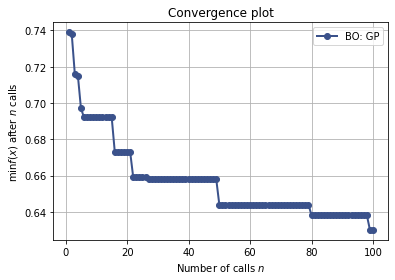

In [9]:
print("....plotting convergence")
from skopt.plots import plot_convergence
plot_convergence(("BO: GP", res_gp))

#### Optimal Geometry 

:::: OPTIMAL GEOMETRY ::::
num_wires:  20


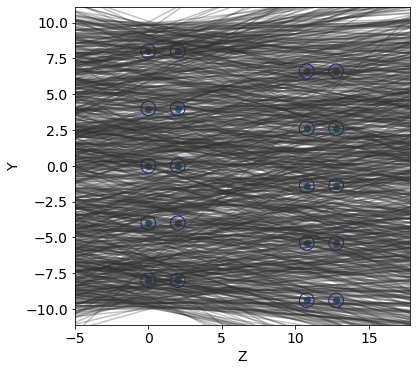

fraction of tracks detected:  0.37


In [10]:

#------------- GEOMETRY ---------------#
print(":::: OPTIMAL GEOMETRY ::::")

tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)
print("num_wires: ", num_wires)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

#a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
print("fraction of tracks detected: ",frac_detected)


### Bayesian Optimization with GBRT

In [11]:
res_gbrt = gbrt_minimize(
    func=obj_fun.objective,  # the function to minimize
    dimensions=dims,  # the bounds on each dimension of x
    acq_func="EI",  # the acquisition function EI
    n_calls= ncalls,  # the number of evaluations of f 
    n_random_starts=15,  # the number of random initialization points
    random_state=rand_st,  # the random seed, use same for reproducibility 
    #kappa=kappa,  # the adjustable parameter of LCB; control variance 
    #xi = xi, # adjustable parameter of either EI, PI: controls improvement
    verbose=False)

print("-------------------------------")
print("-----RESULT FROM BO(GBRT)------")
print("-------------------------------")

print("Objective optimum = ", res_gbrt.fun)
print("Best score = ", 1-res_gbrt.fun)

-------------------------------
-----RESULT FROM BO(GBRT)------
-------------------------------
Objective optimum =  0.637
Best score =  0.363


### Random Search

In [12]:
res_rand = dummy_minimize(
    func=obj_fun.objective,  # the function to minimize
    dimensions=dims,  # the bounds on each dimension of x
    n_calls= ncalls,  # the number of evaluations of f 
    random_state=rand_st,  # the random seed
    verbose=False)

print("-------------------------------")
print("------  RESULT FROM RS  -------")
print("-------------------------------")

print("Objective optimum = ", res_rand.fun)
print("Best score = ", 1-res_rand.fun)

-------------------------------
------  RESULT FROM RS  -------
-------------------------------
Objective optimum =  0.669
Best score =  0.33099999999999996


# Visualization of Results

....plotting convergence


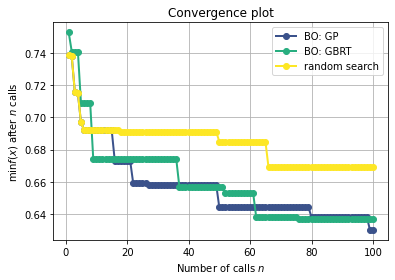

In [13]:
print("....plotting convergence")
from skopt.plots import plot_convergence
plot_convergence(("BO: GP", res_gp),("BO: GBRT", res_gbrt),("random search", res_rand))

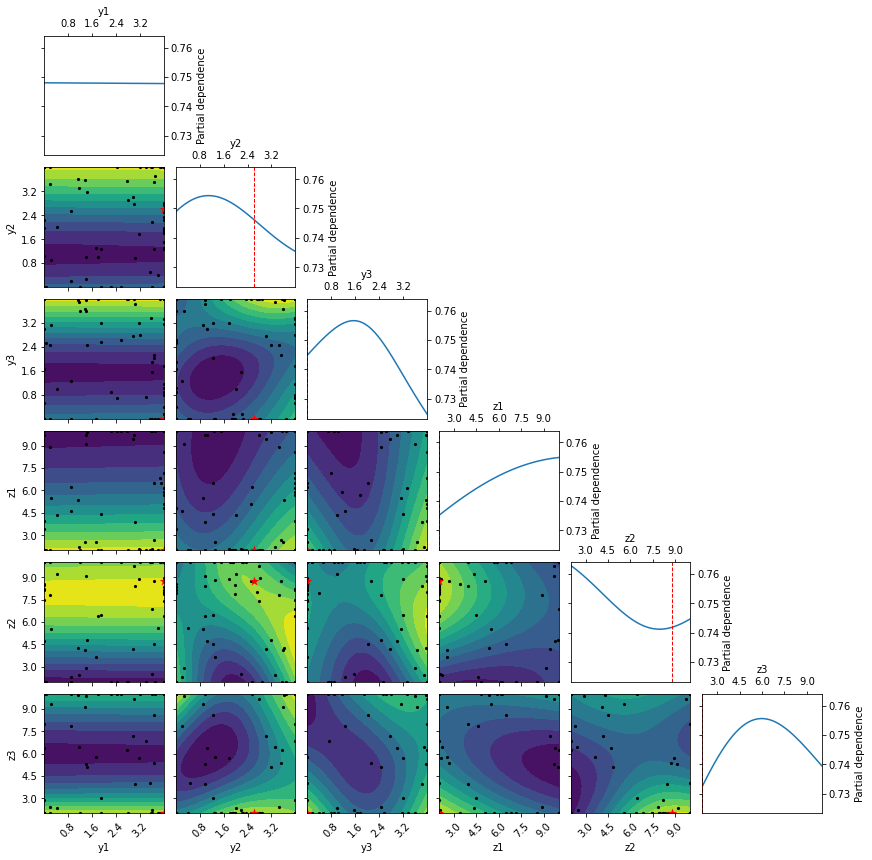

In [14]:
list_str = ["y1", "y2", "y3", "z1", "z2", "z3"] #----"R", "pitch"

from skopt.plots import plot_objective 
_ = plot_objective(res_gp,dimensions=list_str)


---

# Solution 1

1. Increase radius to 1.0 and compare convergence plots of GP and RS with before.

In [15]:
R, pitch = 1.0, 4.0 #to update final plot of optimal geometry  

obj_fun.update_pars(R, pitch)


In [16]:
res_gp_largeR = gp_minimize(
    func=obj_fun.objective,  # the function to minimize
    dimensions=dims,  # the bounds on each dimension of x
    acq_func="gp_hedge", #"gp_hedge",  # the acquisition function EI
    n_calls= ncalls,  # the number of evaluations of f 
    n_random_starts=15,  # the number of random initialization points
    random_state=rand_st,  # the random seed, use same for reproducibility 
    verbose=False)

print("-------------------------------")
print("------  RESULT FROM GP  -------")
print("-------------------------------")

print("Objective optimum = ", res_gp_largeR.fun)
print("Best score = ", 1-res_gp_largeR.fun)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


-------------------------------
------  RESULT FROM GP  -------
-------------------------------
Objective optimum =  0.119
Best score =  0.881


In [17]:
res_rand_largeR = dummy_minimize(
    func=obj_fun.objective,  # the function to minimize
    dimensions=dims,  # the bounds on each dimension of x
    n_calls= ncalls,  # the number of evaluations of f 
    random_state=rand_st,  # the random seed
    verbose=False)

print("-------------------------------")
print("------  RESULT FROM RS  -------")
print("-------------------------------")

print("Objective optimum = ", res_rand_largeR.fun)
print("Best score = ", 1-res_rand_largeR.fun)

-------------------------------
------  RESULT FROM RS  -------
-------------------------------
Objective optimum =  0.20399999999999996
Best score =  0.796


....plotting convergence


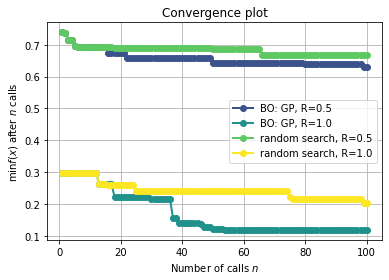

In [18]:
print("....plotting convergence")
from skopt.plots import plot_convergence
plot_convergence(("BO: GP, R=0.5", res_gp),("BO: GP, R=1.0", res_gp_largeR),("random search, R=0.5", res_rand),("random search, R=1.0", res_rand_largeR))

In [19]:
print(res_gp_largeR.fun)
print(res_gp.fun)

0.119
0.63


:::: OPTIMAL GEOMETRY ::::
num_wires:  22


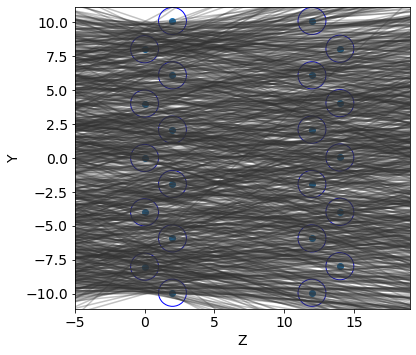

fraction of tracks detected:  0.881


In [20]:
[y1, y2, y3, z1, z2, z3] = res_gp_largeR.x 

#------------- GEOMETRY ---------------#
print(":::: OPTIMAL GEOMETRY ::::")

tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)
print("num_wires: ", num_wires)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

#a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
print("fraction of tracks detected: ",frac_detected)